# **Deribit Open Interest**
Server version of this (Will publish Deribit open interest data to Redis for strategy consumption and also accumulates price history on days leading up to expiry dates): https://github.com/r0bbar/siglab/blob/master/siglab_py/market_data_providers/deribit_options_expiry_provider.py

https://norman-lm-fung.medium.com/monitoring-incoming-deribit-open-interest-fd8c8d596ca0

# Imports

In [ ]:
!pip install ccxt
import os
import sys
import traceback
from enum import Enum
import argparse
from datetime import datetime, timedelta
import time
from typing import Dict, Union, Tuple
import json
import asyncio
import logging
from ccxt import deribit
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from google.colab import files

# **Parameters**

In [ ]:

param : Dict = {
    'market' : 'BTC',

    # Provider ID is part of mds publish topic.
    'provider_id' : 'b0f1b878-c281-43d7-870a-0347f90e6ece',

    'archive_file_name' : "deribit_options_expiry.csv",

    # Publish to message bus
    'mds' : {
        'topics' : {
            'deribit_options_expiry_publish_topic' : 'deribit-options-expiry'
        },
        'redis' : {
            'host' : 'localhost',
            'port' : 6379,
            'db' : 0,
            'ttl_ms' : 1000*60*15 # 15 min?
        }

    }
}

logging.Formatter.converter = time.gmtime
logger = logging.getLogger()
log_level = logging.INFO # DEBUG --> INFO --> WARNING --> ERROR
logger.setLevel(log_level)
format_str = '%(asctime)s %(message)s'
formatter = logging.Formatter(format_str)
sh = logging.StreamHandler()
sh.setLevel(log_level)
sh.setFormatter(formatter)
logger.addHandler(sh)
# fh = logging.FileHandler(f"{param['job_name']}.log")
# fh.setLevel(log_level)
# fh.setFormatter(formatter)
# logger.addHandler(fh)

class LogLevel(Enum):
    CRITICAL = 50
    ERROR = 40
    WARNING = 30
    INFO = 20
    DEBUG = 10
    NOTSET = 0

# **Helper Functions**

In [ ]:
def log(message : str, log_level : LogLevel = LogLevel.INFO):
    if log_level.value<LogLevel.WARNING.value:
        logger.info(f"{datetime.now()} {message}")

    elif log_level.value==LogLevel.WARNING.value:
        logger.warning(f"{datetime.now()} {message}")

    elif log_level.value==LogLevel.ERROR.value:
        logger.error(f"{datetime.now()} {message}")

def fetch_ohlcv_one_candle(
    exchange,
    normalized_symbol : str,
    timestamp_ms : int,
    ref_timeframe : str = '1m'
):
    candles = exchange.fetch_ohlcv(symbol=normalized_symbol, since=int(timestamp_ms), timeframe=ref_timeframe, limit=1)
    one_candle = {
            'timestamp_ms' : candles[0][0],
            'open' : candles[0][1],
            'high' : candles[0][2],
            'low' : candles[0][3],
            'close' : candles[0][4],
            'volume' : candles[0][5]
        } if candles and len(candles)>0 else None

    return one_candle

def timestamp_to_datetime_cols(pd_candles : pd.DataFrame):
    pd_candles['datetime'] = pd_candles['timestamp_ms'].apply(
        lambda x: datetime.fromtimestamp(int(x.timestamp()) if isinstance(x, pd.Timestamp) else int(x / 1000))
    )
    pd_candles['datetime'] = pd.to_datetime(pd_candles['datetime'])
    pd_candles['datetime'] = pd_candles['datetime'].dt.tz_localize(None)
    pd_candles['datetime_utc'] = pd_candles['timestamp_ms'].apply(
        lambda x: datetime.fromtimestamp(int(x.timestamp()) if isinstance(x, pd.Timestamp) else int(x / 1000), tz=timezone.utc)
    )

    # This is to make it easy to do grouping with Excel pivot table
    pd_candles['year'] = pd_candles['datetime'].dt.year
    pd_candles['month'] = pd_candles['datetime'].dt.month
    pd_candles['day'] = pd_candles['datetime'].dt.day
    pd_candles['hour'] = pd_candles['datetime'].dt.hour
    pd_candles['minute'] = pd_candles['datetime'].dt.minute
    pd_candles['dayofweek'] = pd_candles['datetime'].dt.dayofweek  # dayofweek: Monday is 0 and Sunday is 6

def fetch_deribit_btc_option_expiries(
    market: str = 'BTC'
) -> Dict[
    str, Union[
        Dict[str, float],
        Dict[str, Dict[str, Union[str, float]]]
    ]
]:
    exchange = deribit()
    instruments = exchange.public_get_get_instruments({
        'currency': market,
        'kind': 'option',
        # 'expired': 'true'
    })['result']

    index_price = exchange.public_get_get_index_price({
        'index_name': f"{market.lower()}_usd"
    })['result']['index_price']
    index_price = float(index_price)

    expiry_data : Dict[str, float] = {}
    expiry_data_breakdown_by_strike : Dict[str, Dict] = {}
    for instrument in instruments:
        expiry_timestamp = int(instrument["expiration_timestamp"]) / 1000
        expiry_date = datetime.utcfromtimestamp(expiry_timestamp)

        strike = float(instrument['strike'])

        ticker = exchange.public_get_ticker({
            'instrument_name': instrument['instrument_name']
        })['result']

        open_interest = ticker.get("open_interest", 0)  # Open interest in BTC
        open_interest = float(open_interest)
        notional_value : float = open_interest * index_price  # Convert to USD

        expiry_str : str = expiry_date.strftime("%Y-%m-%d")
        if expiry_str not in expiry_data:
            expiry_data[expiry_str] = 0
        expiry_data[expiry_str] += notional_value

        if f"{expiry_str}-{strike}" not in expiry_data_breakdown_by_strike:
            expiry_data_breakdown_by_strike[f"{expiry_str}-{strike}"] = {
                'expiry' : expiry_str,
                'strike' : strike,
                'notional_value' : notional_value
            }
        else:
            expiry_data_breakdown_by_strike[f"{expiry_str}-{strike}"]['notional_value'] += notional_value

    sorted_expiry_data = sorted(expiry_data.items())

    return {
        'index_price' : index_price,
        'by_expiry' : sorted_expiry_data, # type: ignore Otherwise, Error: Type "dict[str, list[tuple[str, float]] | dict[str, Dict[Unknown, Unknown]]]" is not assignable to return type "Dict[str, Dict[str, float] | Dict[str, Dict[str, str | float]]]"
        'by_expiry_and_strike' : expiry_data_breakdown_by_strike
    }

def _fetch_historical_daily_candle_height(
        exchange,
        normalized_symbol : str,
        timestamp_ms : int,
        offset_days : int,
        candle_height : float,
        reload_candle_height : bool = False
    ):
    if not candle_height or reload_candle_height:
        dt = datetime.fromtimestamp(int(timestamp_ms/1000)) + timedelta(days=offset_days)
        dt = datetime(dt.year, dt.month, dt.day)
        timestamp_ms = int(dt.timestamp()) * 1000
        if dt < datetime(datetime.today().year, datetime.today().month, datetime.today().day):
            historical_day_candle = fetch_ohlcv_one_candle(exchange=exchange, normalized_symbol=normalized_symbol, timestamp_ms=timestamp_ms, ref_timeframe='1d')
            if historical_day_candle:
                return historical_day_candle['close'] - historical_day_candle['open']
            else:
                return None
        else:
            return None
    else:
        return None

Fetch Data

In [ ]:
start = time.time()
expiry_data = fetch_deribit_btc_option_expiries(market = param['market'])
index_price = expiry_data['index_price']
expiry_data_by_expiry = expiry_data['by_expiry']
expiry_data_by_expiry_and_strike = expiry_data['by_expiry_and_strike']
elapsed_sec = int((time.time() - start))
log(f"Took {elapsed_sec} sec to fetch option expiry data from Deribit")

INFO:root:2025-01-06 09:41:35.890581 Took 116 sec to fetch option expiry data from Deribit
2025-01-06 09:41:35,890 2025-01-06 09:41:35.890581 Took 116 sec to fetch option expiry data from Deribit
2025-01-06 09:41:35,890 2025-01-06 09:41:35.890581 Took 116 sec to fetch option expiry data from Deribit
2025-01-06 09:41:35,890 2025-01-06 09:41:35.890581 Took 116 sec to fetch option expiry data from Deribit


In [ ]:
pd_expiry_data_by_expiry = pd.DataFrame([ { 'datetime' : x[0], 'notional_usd' : x[1] } for x in expiry_data_by_expiry ])
pd_expiry_data_by_expiry['notional_usd'] = pd_expiry_data_by_expiry['notional_usd'].apply(lambda x: f"{x:,.2f}")
pd_expiry_data_by_expiry


,datetime,notional_usd
0,2025-01-07,"302,703,808.89"
1,2025-01-08,"94,761,433.81"
2,2025-01-09,"1,029,907.94"
3,2025-01-10,"1,546,525,613.45"
4,2025-01-17,"801,050,515.29"
5,2025-01-24,"175,480,468.92"
6,2025-01-31,"5,963,186,801.68"
7,2025-02-28,"1,345,039,968.94"
8,2025-03-28,"7,958,405,675.08"
9,2025-06-27,"2,733,306,362.65"


In [ ]:
pd_expiry_data_by_expiry.to_csv('pd_expiry_data_by_expiry.csv')
files.download('pd_expiry_data_by_expiry.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
pd_expiry_data_by_expiry_and_strike = pd.DataFrame([ { 'datetime' : expiry_data_by_expiry_and_strike[x]['expiry'],'strike' : expiry_data_by_expiry_and_strike[x]['strike'], 'notional_usd' : expiry_data_by_expiry_and_strike[x]['notional_value'] } for x in expiry_data_by_expiry_and_strike ])

In [ ]:
pd_expiry_data_by_expiry_and_strike_export = pd_expiry_data_by_expiry_and_strike.copy()
pd_expiry_data_by_expiry_and_strike_export['notional_usd'] = pd_expiry_data_by_expiry_and_strike_export['notional_usd'].apply(lambda x: f"{x:,.2f}")
pd_expiry_data_by_expiry_and_strike.to_csv('pd_expiry_data_by_expiry_and_strike.csv')
files.download('pd_expiry_data_by_expiry_and_strike.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
pd_expiry_data_by_expiry_and_strike = pd_expiry_data_by_expiry_and_strike[(pd_expiry_data_by_expiry_and_strike.strike>=index_price*0.7) & (pd_expiry_data_by_expiry_and_strike.strike<=index_price*1.3)]

pd_expiry_data_by_expiry_and_strike = pd_expiry_data_by_expiry_and_strike.pivot(
    index='datetime',
    columns='strike',
    values='notional_usd'
)
pd_expiry_data_by_expiry_and_strike = pd_expiry_data_by_expiry_and_strike.dropna(how='all', axis=0).dropna(how='all', axis=1)
pd_expiry_data_by_expiry_and_strike.columns.name = None

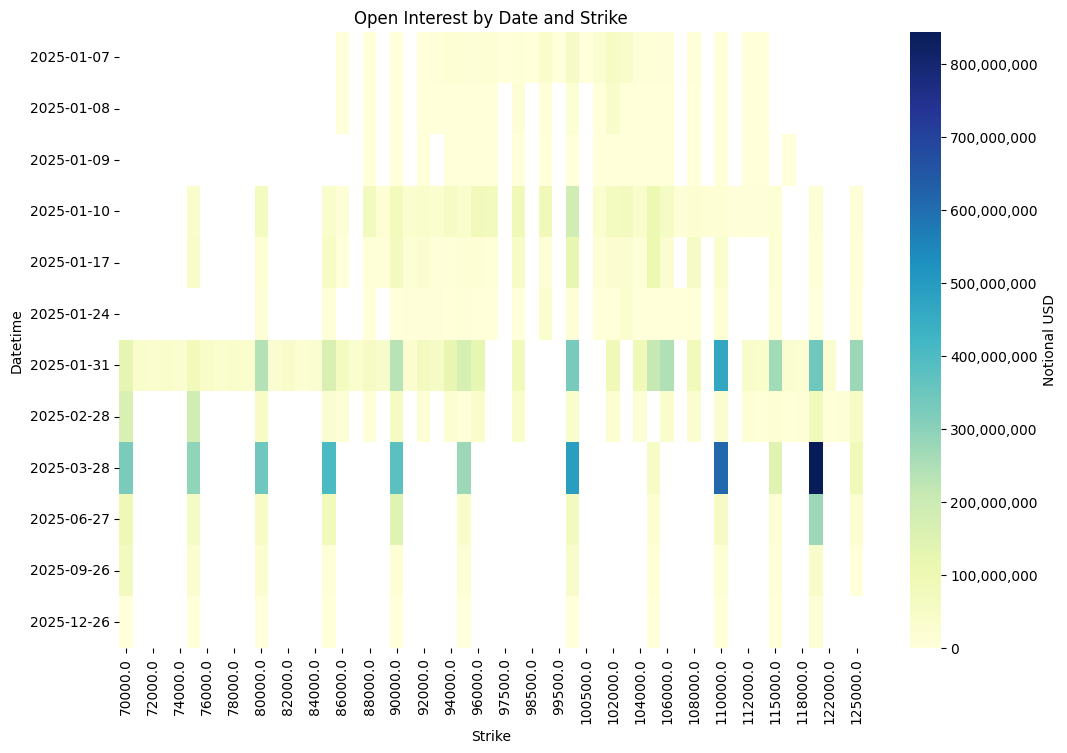

In [ ]:
plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(
    pd_expiry_data_by_expiry_and_strike.astype(float),
    annot=False,
    cmap="YlGnBu",
    cbar_kws={'label': 'Notional USD'}
)

colorbar = heatmap.collections[0].colorbar
colorbar.formatter = ticker.FuncFormatter(lambda x, _: f'{x:,.0f}')
colorbar.update_ticks()

plt.title("Open Interest by Date and Strike")
plt.xlabel("Strike")
plt.ylabel("Datetime")
plt.show()